In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime, date, timedelta

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite", echo=True)

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

2024-04-15 14:52:33,761 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2024-04-15 14:52:33,761 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-04-15 14:52:33,762 INFO sqlalchemy.engine.Engine PRAGMA main.table_xinfo("measurement")
2024-04-15 14:52:33,762 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-04-15 14:52:33,763 INFO sqlalchemy.engine.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = ? AND type = 'table'
2024-04-15 14:52:33,763 INFO sqlalchemy.engine.Engine [raw sql] ('measurement',)
2024-04-15 14:52:33,764 INFO sqlalchemy.engine.Engine PRAGMA main.foreign_key_list("measurement")
2024-04-15 14:52:33,764 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-04-15 14:52:33,765 INFO sqlalchemy.engine.Engine PRAGMA temp.foreign_key_list("measurement")
2024-04-15 14:52:33,765 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-04-15 14:52:33,765 INFO sqlalchemy.engine.Engine SELECT sql

/var/folders/g5/9hfflczn7jqg6nc58wj_9_sm0000gn/T/ipykernel_39229/4196587217.py:4: RemovedIn20Warning: Deprecated API features detected! These feature(s) are not compatible with SQLAlchemy 2.0. To prevent incompatible upgrades prior to updating applications, ensure requirements files are pinned to "sqlalchemy<2.0". Set environment variable SQLALCHEMY_WARN_20=1 to show all deprecation warnings.  Set environment variable SQLALCHEMY_SILENCE_UBER_WARNING=1 to silence this message. (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
station = Base.classes.station
measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
most_recent_date = most_recent_date[0]
print(most_recent_date)

2024-04-15 14:52:33,795 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-04-15 14:52:33,797 INFO sqlalchemy.engine.Engine SELECT measurement.date AS measurement_date 
FROM measurement ORDER BY measurement.date DESC
 LIMIT ? OFFSET ?
2024-04-15 14:52:33,797 INFO sqlalchemy.engine.Engine [generated in 0.00039s] (1, 0)
2017-08-23


2024-04-15 14:52:33,842 INFO sqlalchemy.engine.Engine SELECT measurement.date AS measurement_date, measurement.prcp AS measurement_prcp 
FROM measurement 
WHERE measurement.date >= ? AND measurement.date <= ?
2024-04-15 14:52:33,852 INFO sqlalchemy.engine.Engine [generated in 0.01049s] ('2016-08-23 00:00:00.000000', '2017-08-23 00:00:00.000000')


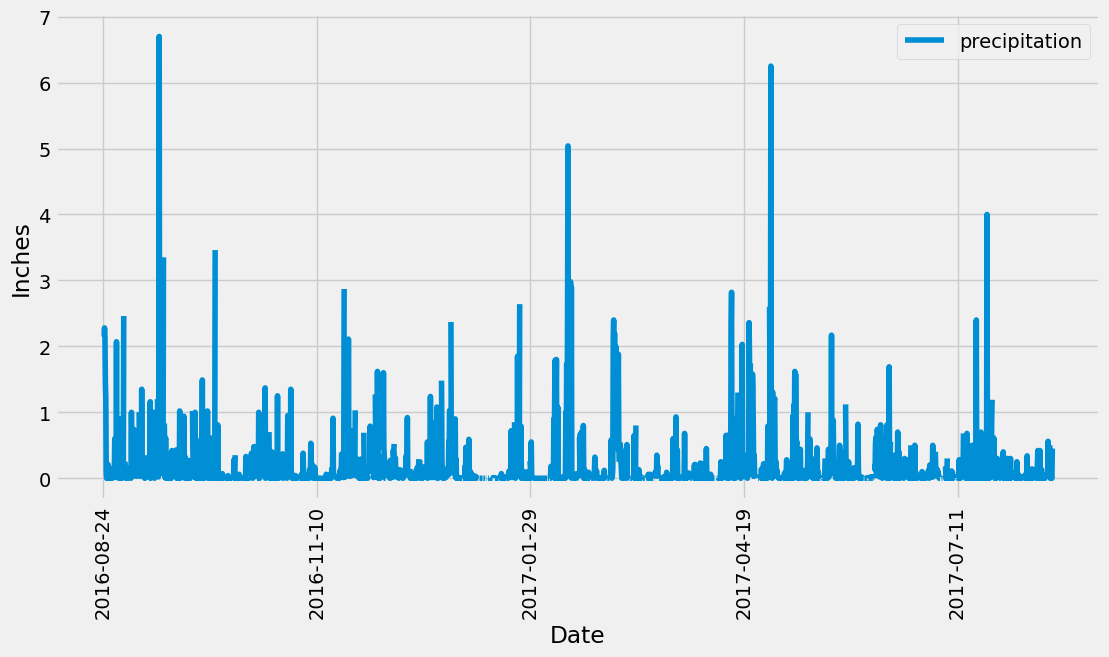

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = datetime.strptime(most_recent_date, '%Y-%m-%d')
one_year_ago = most_recent_date - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(measurement.date, measurement.prcp) \
    .filter(measurement.date >= one_year_ago) \
    .filter(measurement.date <= most_recent_date) \
    .all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['date', 'precipitation'])

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='date')

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(x='date', y='precipitation', figsize=(12, 6))
plt.xlabel('Date')
plt.ylabel('Inches')
plt.xticks(rotation=90)
plt.show()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_stats = precipitation_df.describe()
precipitation_stats

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(station.station).distinct().count()
total_stations

2024-04-15 14:52:33,997 INFO sqlalchemy.engine.Engine SELECT count(*) AS count_1 
FROM (SELECT DISTINCT station.station AS station_station 
FROM station) AS anon_1
2024-04-15 14:52:33,998 INFO sqlalchemy.engine.Engine [generated in 0.00128s] ()


9

In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station).label('count')) \
                    .group_by(measurement.station) \
                    .order_by(func.count(measurement.station).desc()) \
                    .all()
active_stations

2024-04-15 14:52:34,007 INFO sqlalchemy.engine.Engine SELECT measurement.station AS measurement_station, count(measurement.station) AS count 
FROM measurement GROUP BY measurement.station ORDER BY count(measurement.station) DESC
2024-04-15 14:52:34,008 INFO sqlalchemy.engine.Engine [generated in 0.00095s] ()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Solve for most active station
most_active_station = session.query(measurement.station, func.count(measurement.station).label('count')) \
                        .group_by(measurement.station) \
                        .order_by(desc('count')) \
                        .first()[0]
# Check function works properly
#print(most_active_station)

# Find temperature stats for most active station
temp_stats = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)) \
                .filter(measurement.station == most_active_station) \
                .first()
temp_stats

2024-04-15 14:52:34,021 INFO sqlalchemy.engine.Engine SELECT measurement.station AS measurement_station, count(measurement.station) AS count 
FROM measurement GROUP BY measurement.station ORDER BY count DESC
 LIMIT ? OFFSET ?
2024-04-15 14:52:34,023 INFO sqlalchemy.engine.Engine [generated in 0.00185s] (1, 0)
2024-04-15 14:52:34,028 INFO sqlalchemy.engine.Engine SELECT min(measurement.tobs) AS min_1, max(measurement.tobs) AS max_1, avg(measurement.tobs) AS avg_1 
FROM measurement 
WHERE measurement.station = ?
 LIMIT ? OFFSET ?
2024-04-15 14:52:34,029 INFO sqlalchemy.engine.Engine [generated in 0.00074s] ('USC00519281', 1, 0)


(54.0, 85.0, 71.66378066378067)

2024-04-15 14:52:34,039 INFO sqlalchemy.engine.Engine SELECT measurement.date AS measurement_date 
FROM measurement ORDER BY measurement.date DESC
 LIMIT ? OFFSET ?
2024-04-15 14:52:34,040 INFO sqlalchemy.engine.Engine [cached since 0.2431s ago] (1, 0)
2024-04-15 14:52:34,042 INFO sqlalchemy.engine.Engine SELECT measurement.tobs AS measurement_tobs 
FROM measurement 
WHERE measurement.station = ? AND measurement.date >= ?
2024-04-15 14:52:34,043 INFO sqlalchemy.engine.Engine [generated in 0.00061s] ('USC00519281', '2016-08-23')


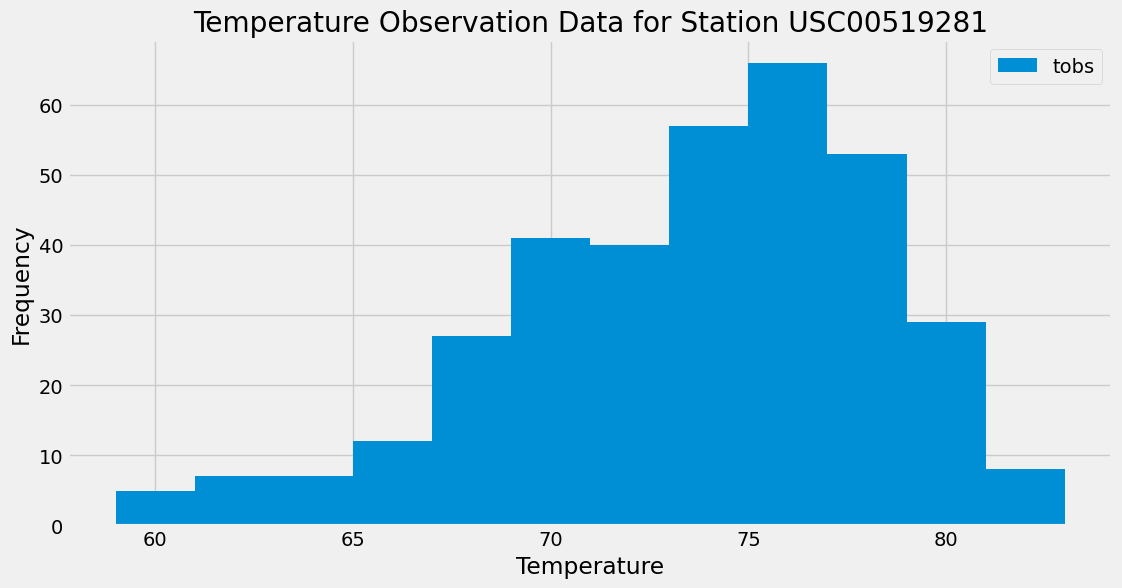

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Find most recent date and one year prior
most_recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()[0]
most_recent_date = datetime.strptime(most_recent_date, '%Y-%m-%d')
one_year_ago = most_recent_date.replace(year=most_recent_date.year - 1)

# Query for 12 months of temperature observations for most active station
temp_data = session.query(measurement.tobs) \
                .filter(measurement.station == most_active_station) \
                .filter(measurement.date >= one_year_ago.strftime('%Y-%m-%d')) \
                .all()

# Convert query in pandas DataFrame
temp_df = pd.DataFrame(temp_data, columns=['temperature'])

# Plot the temperature data as a histogram
plt.figure(figsize=(12, 6))
plt.hist(temp_df['temperature'], bins=12, label='tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Temperature Observation Data for Station USC00519281') 
plt.legend()
plt.show()

# Close Session

In [17]:
# Close Session
session.close()

2024-04-15 14:52:34,171 INFO sqlalchemy.engine.Engine ROLLBACK
